In [1]:
import json
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load and preprocess data
file_path = "/content/drive/MyDrive/Assignment 1/z639_assignment1_training.json"
with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df['toxic'] = df['composite_toxic'].apply(lambda annotations: sum(ann[0] for ann in annotations) > len(annotations) / 2)

In [4]:
# Stratified split (shared by both models)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['toxic'], random_state=42)

In [13]:
# ====================== Logistic Regression Model ======================
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    ngram_range=(1,3),
    sublinear_tf=True,
    min_df=3,
    max_df=0.9
)
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])

# Model training
log_reg = LogisticRegression(
    max_iter=1000,
    C=0.0001,
    solver="saga",
    class_weight="balanced",
    penalty="l2"
)
log_reg.fit(X_train, train_df['toxic'])

# ======== Metrics Calculation ========
# Training set predictions
train_preds = log_reg.predict(X_train)
train_proba = log_reg.predict_proba(X_train)

# Validation set predictions
val_preds = log_reg.predict(X_val)
val_proba = log_reg.predict_proba(X_val)

# Calculate metrics
metrics = {
    "Training": {
        "Accuracy": accuracy_score(train_df['toxic'], train_preds),
        "Precision": precision_score(train_df['toxic'], train_preds, zero_division=0),
        "Recall": recall_score(train_df['toxic'], train_preds, zero_division=0),
        "F1": f1_score(train_df['toxic'], train_preds, zero_division=0),
        "Log Loss": log_loss(train_df['toxic'], train_proba)
    },
    "Validation": {
        "Accuracy": accuracy_score(val_df['toxic'], val_preds),
        "Precision": precision_score(val_df['toxic'], val_preds, zero_division=0),
        "Recall": recall_score(val_df['toxic'], val_preds, zero_division=0),
        "F1": f1_score(val_df['toxic'], val_preds, zero_division=0),
        "Log Loss": log_loss(val_df['toxic'], val_proba)
    }
}

# ======== Display Results ========
results_df = pd.DataFrame(metrics).T.round(4)
print("\n📊 Logistic Regression Performance Comparison:")
print(results_df)


📊 Logistic Regression Performance Comparison:
            Accuracy  Precision  Recall      F1  Log Loss
Training      0.8056     0.6095  0.6748  0.6405    0.6931
Validation    0.7562     0.5260  0.4927  0.5088    0.6931


In [24]:
# ====================== DistilBERT Model ======================
set_seed = lambda seed=42: (torch.manual_seed(seed), torch.cuda.manual_seed_all(seed))
set_seed(42)

# Convert labels to integers upfront
train_df['toxic'] = train_df['toxic'].astype(int)
val_df['toxic'] = val_df['toxic'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.4

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if isinstance(self.texts, pd.Series) else self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Safely handle label conversion
        label = int(self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx])

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = ToxicCommentsDataset(train_df['text'], train_df['toxic'], tokenizer)
val_dataset = ToxicCommentsDataset(val_df['text'], val_df['toxic'], tokenizer)

# Training setup with updated parameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.3,
    eval_strategy="epoch",  # ✅ Correct parameter name
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=50,
    logging_first_step=True,
    report_to="none"  # ✅ Disable wandb integration
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
        "f1": f1_score(labels, preds, average="binary")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# Train and evaluate
print("Training DistilBERT...")
trainer.train()
bert_metrics = trainer.evaluate(val_dataset)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.496700,0.459849,0.803750,0.744898,0.356098,0.481848
2,0.454500,0.455830,0.782500,0.563265,0.673171,0.613333
3,0.426500,0.472410,0.783750,0.572727,0.614634,0.592941


In [25]:
# ====================== Results Comparison ======================
# Extract validation metrics for Logistic Regression
log_reg_val_metrics = metrics["Validation"]

# Create a comparison DataFrame
results = pd.DataFrame({
    "Model": ["DistilBERT", "Logistic Regression"],
    "Accuracy": [bert_metrics["eval_accuracy"], log_reg_val_metrics["Accuracy"]],
    "Precision": [bert_metrics["eval_precision"], log_reg_val_metrics["Precision"]],
    "Recall": [bert_metrics["eval_recall"], log_reg_val_metrics["Recall"]],
    "F1-Score": [bert_metrics["eval_f1"], log_reg_val_metrics["F1"]]
}).round(4)

# Display the results
print("\n=== Validation Set Performance Comparison ===")
print(results)


=== Validation Set Performance Comparison ===
                 Model  Accuracy  Precision  Recall  F1-Score
0           DistilBERT    0.7825     0.5633  0.6732    0.6133
1  Logistic Regression    0.7562     0.5260  0.4927    0.5088


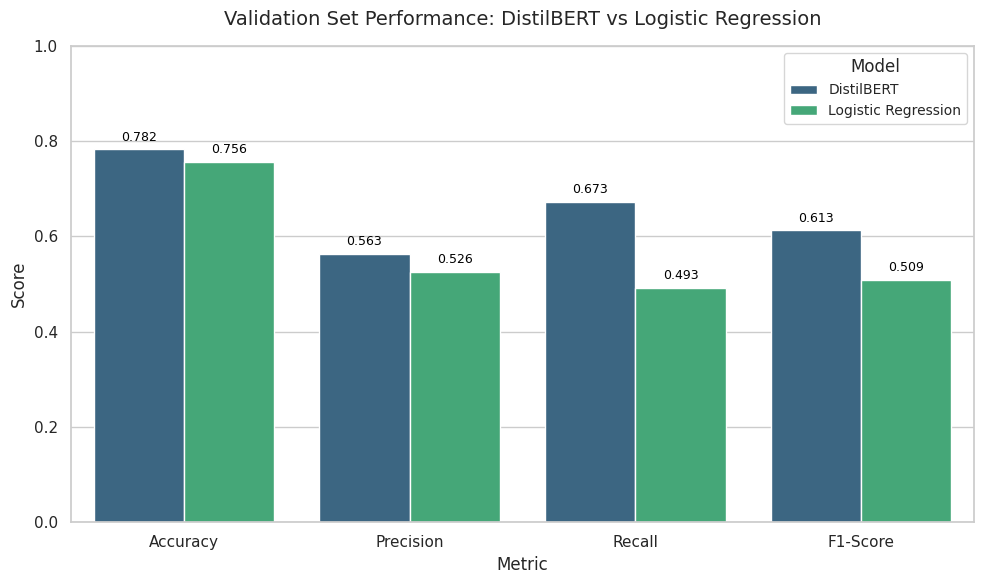

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjusted figure size

# Melt the results DataFrame for easier plotting
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create the bar plot
sns.barplot(x="Metric", y="Score", hue="Model", data=results_melted, palette="viridis")

# Add titles and labels
plt.title("Validation Set Performance: DistilBERT vs Logistic Regression", fontsize=14, pad=15)  # Adjusted title size
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better readability
plt.legend(title="Model", loc="upper right", fontsize=10)  # Adjusted legend size

# Annotate bars only if height > 0
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(
            f"{height:.3f}",  # Reduced to 3 decimal places for clarity
            (p.get_x() + p.get_width() / 2., height),
            ha="center",
            va="bottom",
            fontsize=9,
            color="black",
            xytext=(0, 4),
            textcoords="offset points"
        )

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


**Model Predictions**

In [ ]:
import os
print(os.listdir("./results/checkpoint-800"))


['config.json', 'optimizer.pt', 'rng_state.pth', 'model.safetensors', 'scheduler.pt', 'trainer_state.json', 'training_args.bin']


In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from safetensors.torch import load_file

# Load test dataset
test_df = pd.read_json("/content/drive/MyDrive/Assignment 1/z639_assignment1_test.json", lines=True)

# Load tokenizer from pre-trained DistilBERT model (NOT from checkpoint directory)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load fine-tuned model from checkpoint
model_path = "./results/checkpoint-800"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.load_state_dict(load_file(model_path + "/model.safetensors"))

# Move model to available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict toxicity
def predict_toxicity(texts):
    model.eval()  # Set model to evaluation mode
    predictions = []

    for text in texts:
        encoding = tokenizer(
            text, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits

        pred_label = torch.argmax(logits, dim=-1).cpu().numpy()[0]
        predictions.append(pred_label)

    return predictions

# Predict toxicity for test dataset
test_df["prediction"] = predict_toxicity(test_df["text"])

# Convert predictions to boolean format (true = toxic, false = non-toxic)
test_df["prediction"] = test_df["prediction"].map({0: False, 1: True})

# Save predictions in required format
submission_df = test_df[["platform_id", "prediction"]]
submission_df.to_csv("distilbert_predictions.csv", index=False)

print("✅ Predictions saved to distilbert_predictions.csv")


✅ Predictions saved to distilbert_predictions.csv
